# Convolución de matrices

In [1]:
import matplotlib.image as img
from PIL import Image
from functools import reduce
import numpy as np

## Definición de funciones

Uno de los principios de la programación funcional consiste en crear funciones que se asemejen a funciones matemáticas, esto es, que los datos que retornen representen una transformación de sus datos de entrada, sin causar modificaciones en otras partes del programa ni verse afectadas por otros factores externos. Para esto, usaremos las funciones `lambda` de python, que ayudarán a mantener una buena legibilidad.

Como la matriz de la imagen contiene vectores de tres elementos, tendremos que definir una función para realizar la multiplicación de un entero con una tupla, usando funciones lambda tendremos:

In [2]:
# multiplicación de un entero y una tupla
mult_int_tuple = lambda i, a, b, c : (i*a, i*b, i*c)

Como vemos, esta función toma cuatro argumentos y los devuelve transformados, sin realizar asignaciones de variables. En programación funcional no se usan variables, sino funciones que devuelven valores constantes, por tanto no pueden hacerse asignaciones a estas una vez definidas.

Para evitarnos la necesidad de hacer asignaciones de variables, haremos uso en muchos casos de una característica de python: *unpacking* que consiste en realizar asignaciones a tuplas, de modo que se pueden hacer asignaciones de varios valores a la vez o incluso recibir en una tupla los valores de una función que devuelva más de un valor. Pero dijimos que no usaríamos asignaciones, así que usaremos otro aspecto del *unpacking*, en este caso al llamar a funciones, en lugar de llamar a la función `mult_int_trip` con cuatro argumentos, lo haremos con dos: un entero y una tupla de tres elementos, para esto, llamaremos a la función con la siguiente sintaxis:
```
mult_int_trip(i, *t)
```
Donde `i` es un entero y `t` una tupla, nótese que el símbolo de asterisco (`*`) delante de `t` nos permite mapear los tres valores de la tupla `t` en las variables `a`, `b` y `c` de la función, de no incluirlo, tendríamos errores en la ejecución, ya que la función espera cuatro argumentos y estaríamos enviando sólo dos.

De forma similar a la anterior, definiremos otras funciones que requeriremos en el futuro.

In [3]:
# división de una tupla por un entero
div_tuple_int = lambda i, a, b, c : (a/i, b/i, c/i)

# suma de un entero a los elementos de una tupla
sum_tuple_int = lambda i, a, b, c : (a+i, b+i, c+i)

# suma de dos tuplas
sum_tuples = lambda a, b : (a[0]+b[0], a[1]+b[1], a[2]+b[2])

Además tomaremos algunos otros detalles en cuenta, ya que se trata de colores formados por tres valores (rojo, verde y azul), tendremos que controlar que no se salgan del rango $[0, 255]$. para esto crearemos las siguientes funciones:

In [4]:
ib = lambda x : 0 if x < 0 else 255 if x > 255 else x
in_bounds = lambda x, y, z : (ib(x), ib(y), ib(z))

La primera función, `ib`, recibe un número y comprueba que se encuentre en el rango correcto, si es menor que 0 devolverá 0 y si es mayor que 255 devolverá 255, para los demás casos devolverá el mismo valor de entrada. En la segunda función, realizamos la misma tarea pero para una tupla de tres elementos, haciendo uso de la función `ib` para cada elemento.



Para esto, definiremos una función que reciba como entrada una imagen y las coordenadas de un pixel y nos devuelva una lista de los pixeles circundantes, el orden es importante, tendremos que mantener el mismo orden en el kernel también, de modo que la correspondencia no se vea afectada.

In [5]:
get_surroundings = lambda image, row, col : \
          [image[row-1][col-1], image[row][col-1], image[row+1][col-1],  \
           image[row-1][col],   image[row][col],   image[row+1][col],    \
           image[row-1][col+1], image[row][col+1], image[row+1][col+1]]

Ya que estaremos aplicando una función a cada elemento de dos listas, también definiremos la función `zipWith`, esta función nos permitirá realizar operaciones de manera directa en dos vectores sin tener que iterar sobre ellos (al menos no de manera explícita).

In [6]:
zipwith_tuples = lambda f, li, lt : [f(i, *t) for (i, t) in zip(li, lt)]

Esta función, toma como argumentos una función `f`, una lista de enteros `li` y una lista de tuplas `lt`, y devuelve una lista que definimos usando la sintaxis de listas de comprensión de python, cuyos elementos son resultado de aplicar la función `f` sobre un par de elementos `i` y `t` que obtendremos de la unión - elemento a elemento - de las listas `li` y `lt`.

Esta unión la realiza la función `zip` que devuelve una lista de tuplas en que el primer elemento pertenece a la primera lista y el segundo a la segunda lista.

## Función convolución

Ahora definimos la función que realizará la convolución como indica la fórmula que vimos anteriormente.


In [7]:
def convolution(arri, arrt, factor, offset):
    trip = reduce(sum_tuples, zipwith_tuples(mult_int_tuple, arri, arrt))
    trip = div_tuple_int(factor, *trip)
    trip = sum_tuple_int(offset, *trip)
    return trip

Esta función recibe como parámetros las dos matrices a operar, el factor por el que dividiremos el resultado, y un offset que podremos usar para controlar el brillo que tenga la imagen, si es que después del proceso este varía. Este es un valor que sumaremos a cada color de cada pixel.

Finalmente definimos una función más, donde haremos la iteración por cada pixel de la imagen ejecutando la función `convolution`, esta función recibirá como argumentos una imagen, el kernel que elijamos, el factor y el offset, para devolvernos una nueva imagen procesada.

In [8]:
def make_convolution(image_file, kernel, factor, offset):
    (height, width, dat) = image_file.shape
    image = image_file.tolist()
    image2 = [[[0,0,0] for j in range(width)] for i in range(height)]
    for row in range(1, height-1):
        for col in range(1, width-1):
            arr = get_surroundings(image, row, col)
            arrt = convolution(kernel, arr, factor, offset)
            image2[row][col] = in_bounds(*arrt)
    return image2


In [18]:
image_file = img.imread("penguin1.jpg")

## Detección de bordes

Existen varios kernels que, aplicados a una imagen, muestran los bordes de los objetos mostrados en la imagen, basados en la variación del color.

Probaremos primero con esta imagen:

![](penguin1.jpg)

In [10]:
border = [ -1, -1, -1, \
           -1,  8, -1, \
           -1, -1, -1]
factor = 1
offset = 0

image2 = make_convolution(image_file, border, factor, offset)

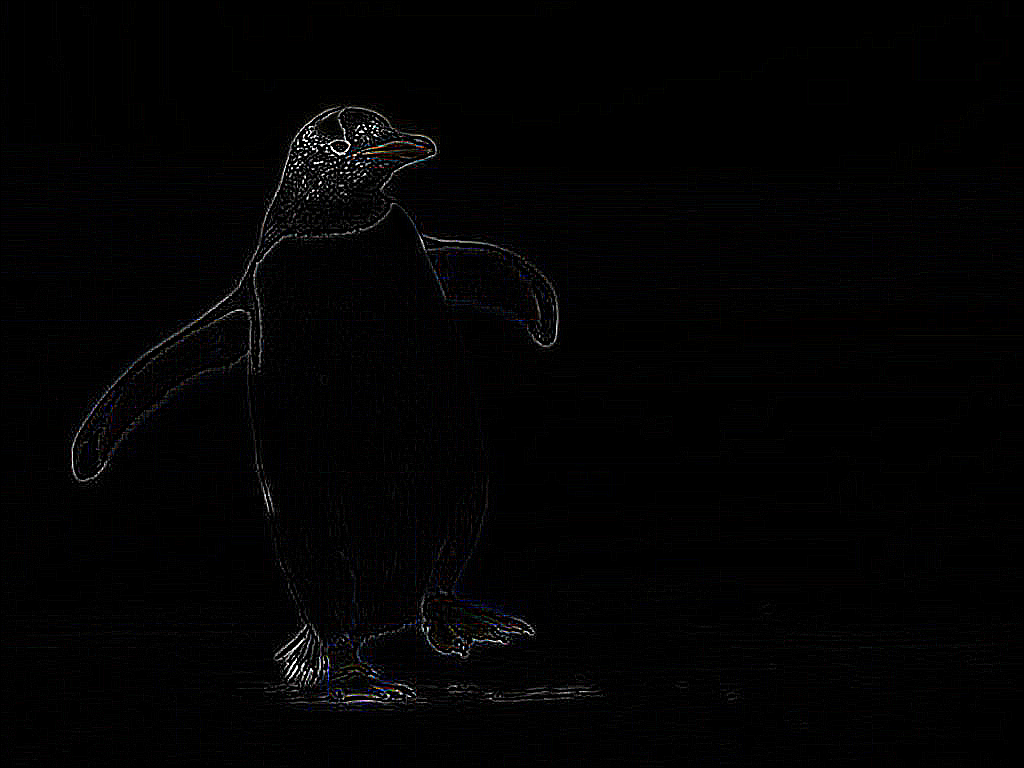

In [11]:
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

Otro ejemplo de detección de bordes:

In [12]:
border2 = [-1, 0, -1, \
            0, 4,  0, \
           -1, 0, -1]
factor = 1
offset = 0

image2 = make_convolution(image_file, border2, factor, offset)

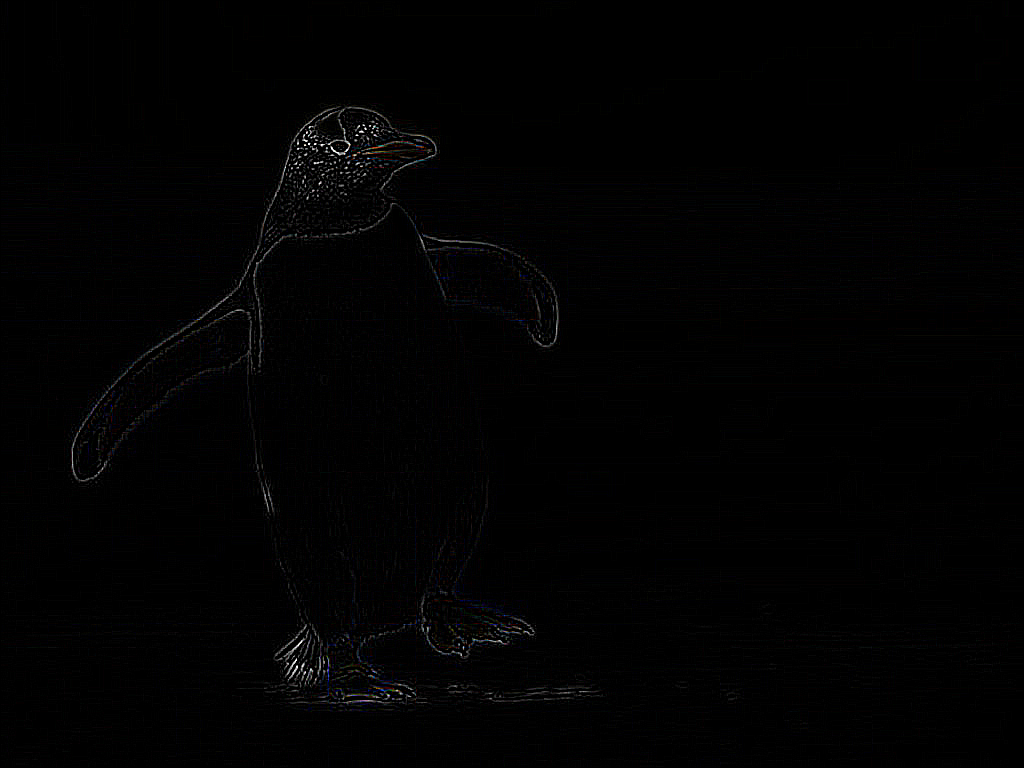

In [13]:
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

Ahora probamos con otra imagen, con bordes más definidos.

![](penguin2.jpg)

In [24]:
image_file = img.imread("penguin2.jpg")

border = [ -1, -1, -1, \
           -1,  8, -1, \
           -1, -1, -1]
factor = 1
offset = 0

image2 = make_convolution(image_file, border, factor, offset)

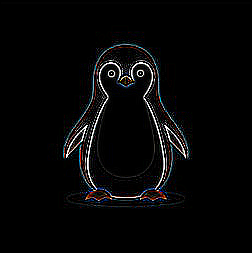

In [25]:
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

Con el segundo kernel que probamos:

In [26]:
border2 = [-1, 0, -1, \
            0, 4,  0, \
           -1, 0, -1]
factor = 1
offset = 0

image2 = make_convolution(image_file, border2, factor, offset)

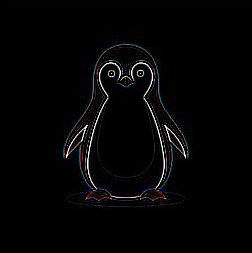

In [27]:
image2_arr = np.asarray(image2, dtype="uint8")
img_file = Image.fromarray(image2_arr, 'RGB')
img_file

## Referencias

Giménez Palomares, F., Monsoriu Serrá, J., & Alemany Martínez, E. (2016). Aplicación de la convolución de matrices al filtrado de imágenes. Modelling in Science Education and Learning, 9(1), 97-108. doi:https://doi.org/10.4995/msel.2016.4524

Ludwig, J. (2013). Image convolution. Portland State University.

Patin, F. (2003). An introduction to digital image processing. online]: http://www. programmersheaven. com/articles/patin/ImageProc. pdf.